# Nowcasting financial crisis with deep learning techniques

In [279]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


## Import the dataset

In [218]:
ds = pd.read_excel("/content/StockBond.xlsx")

In [219]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5723 entries, 0 to 5722
Data columns (total 56 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   DATA                                                    5723 non-null   datetime64[ns]
 1   S&P 500 COMPOSITE - PRICE INDEX                         5723 non-null   float64       
 2   S&P/TSX COMPOSITE INDEX - PRICE INDEX (CANADA)          5723 non-null   float64       
 3   MSCI ARGENTINA - PRICE INDEX                            5723 non-null   float64       
 4   S&P/BVL GENERAL(IGBVL) - PRICE INDEX (PERU)             5723 non-null   float64       
 5   BRAZIL BOVESPA - TOT RETURN IND                         5723 non-null   float64       
 6   S&P/CLX IGPA CLP INDEX - PRICE INDEX (CHILE)            5723 non-null   float64       
 7   MEXICO BANAMEX - PRICE INDEX                            5723

How many days with a financial crisis we have?

In [220]:
ds["CRISI"].sum()

1640.0

In [221]:
ds[ds["CRISI"] > 0][['DATA', 'NOTE']].head()

,DATA,NOTE
385,1997-07-02,Asian Flu
678,1998-08-17,Russian Virus
705,1998-09-23,LTCM
730,1998-10-28,Hong-Kong stock market crash
785,1999-01-13,currency devaluation in Brazil


## Data preparation

We calculated the initial empirical distribution of returns (pertaining to the first day in our analysis) based on the stock index returns of the first 200 observations (covering the period 10/01/1996–15/10/1996). For each subsequent record (day in the examined period), we recalculated the empirical distribution of returns in order to incorporate the new observation.

Then, an event was identified if the return was below the first percentile of the new empirical distribution. Thus, for the last observation in the sample (i.e. 15/12/2017), the empirical distribution of returns was based on the period: 10/01/1996–14/12/2017

First of all we need to compute the returns

In [222]:
ds["returns"] = (ds["S&P 500 COMPOSITE - PRICE INDEX"]- ds["S&P 500 COMPOSITE - PRICE INDEX"].shift(1))/ds["S&P 500 COMPOSITE - PRICE INDEX"].shift(1)

In [223]:
ds['ecdf_1']= ds["returns"].rolling(200).quantile(.1, interpolation='lower')
ds['ecdf_5']= ds["returns"].rolling(200).quantile(.5, interpolation='lower')


An event is identified as "outlier", if the return was below the thresold (first percentile or five percentuile), or of the new empirical distribution.\

In [224]:
ds['c_1'] = np.where(ds['ecdf_1'] >=  ds['returns'], 1, 0)
ds['c_5'] = np.where(ds['ecdf_5'] >=  ds['returns'], 1, 0)

Let's check the results... as you can see we start to indetify potential issue.

In [225]:
ds[ds["c_5"] > 0].head()

,DATA,S&P 500 COMPOSITE - PRICE INDEX,S&P/TSX COMPOSITE INDEX - PRICE INDEX (CANADA),MSCI ARGENTINA - PRICE INDEX,S&P/BVL GENERAL(IGBVL) - PRICE INDEX (PERU),BRAZIL BOVESPA - TOT RETURN IND,S&P/CLX IGPA CLP INDEX - PRICE INDEX (CHILE),MEXICO BANAMEX - PRICE INDEX,DAX 30 PERFORMANCE - PRICE INDEX (GERMANY),FTSE 100 - PRICE INDEX (UK),...,HONG_KONG_YIELD,YUAN_TO_US,YEN_TO_US,US_TO_EURO,US_TO_POUND,returns,ecdf_1,ecdf_5,c_1,c_5
203,1996-10-21,709.85,5518.08,2517909.516,1567.1,6798.9,5484.13,2181.96,2729.03,4073.1,...,NaN,8.3,112.23,1.27133,1.5905,-0.001365,-0.007464,0.000416,0,1
204,1996-10-22,706.57,5532.99,2487906.044,1554.2,6675.6,5457.00,2152.82,2718.98,4057.2,...,NaN,8.3,112.05,1.27238,1.5973,-0.004621,-0.007464,0.000347,0,1
206,1996-10-24,702.29,5558.86,2496259.576,1542.0,6588.8,5455.49,2163.11,2678.43,3999.4,...,NaN,8.3,112.37,1.28111,1.5918,-0.007041,-0.007464,0.000347,0,1
207,1996-10-25,700.92,5549.78,2494437.257,1550.3,6503.3,5443.47,2135.54,2674.22,4022.4,...,NaN,8.3,112.68,1.28187,1.6038,-0.001951,-0.007464,0.000334,0,1
208,1996-10-28,697.26,5553.36,2509710.532,1554.6,6401.0,5432.53,2123.37,2703.83,4025.3,...,NaN,8.3,113.39,1.28408,1.6123,-0.005222,-0.007464,0.000321,0,1


Now we need to apply the some pre-processing to all the columns

In [410]:
ds = pd.read_excel("/content/StockBond.xlsx")
list_of_features = ds.columns.to_list()
list_of_features

['DATA',
 'S&P 500 COMPOSITE - PRICE INDEX',
 'S&P/TSX COMPOSITE INDEX - PRICE INDEX (CANADA)',
 'MSCI ARGENTINA - PRICE INDEX',
 'S&P/BVL GENERAL(IGBVL) - PRICE INDEX (PERU)',
 'BRAZIL BOVESPA - TOT RETURN IND',
 'S&P/CLX IGPA CLP INDEX - PRICE INDEX (CHILE)',
 'MEXICO BANAMEX - PRICE INDEX',
 'DAX 30 PERFORMANCE - PRICE INDEX (GERMANY)',
 'FTSE 100 - PRICE INDEX (UK)',
 'FRANCE CAC 40 - PRICE INDEX',
 'RUSSIA RTS INDEX - PRICE INDEX',
 'IBEX 35 - PRICE INDEX (SPAIN)',
 'FTSE ITALIA MIB STORICO - PRICE INDEX',
 'AEX INDEX (AEX) - PRICE INDEX (NETHERLANDS)',
 'SWISS MARKET (SMI) - PRICE INDEX',
 'OMX STOCKHOLM 30 (OMXS30) - PRICE INDEX (SWEDEN)',
 'MSCI POLAND - PRICE INDEX',
 'BEL 20 - PRICE INDEX (BELGIUM)',
 'ATX - AUSTRIAN TRADED INDEX - PRICE INDEX (AUSTRIA)',
 'MSCI NORWAY - PRICE INDEX',
 'TEL AVIV SE TA-35 - PRICE INDEX (ISRAEL)',
 'OMX COPENHAGEN (OMXC20) - PRICE INDEX (DENMARK)',
 'ISEQ ALL SHARE INDEX - PRICE INDEX (IRELAND)',
 'ATHEX COMPOSITE - PRICE INDEX (GREECE)',
 'PRA

In [411]:
list_of_features.remove('DATA')
list_of_features.remove('CRISI')
list_of_features.remove('NOTE')
list_of_features

['S&P 500 COMPOSITE - PRICE INDEX',
 'S&P/TSX COMPOSITE INDEX - PRICE INDEX (CANADA)',
 'MSCI ARGENTINA - PRICE INDEX',
 'S&P/BVL GENERAL(IGBVL) - PRICE INDEX (PERU)',
 'BRAZIL BOVESPA - TOT RETURN IND',
 'S&P/CLX IGPA CLP INDEX - PRICE INDEX (CHILE)',
 'MEXICO BANAMEX - PRICE INDEX',
 'DAX 30 PERFORMANCE - PRICE INDEX (GERMANY)',
 'FTSE 100 - PRICE INDEX (UK)',
 'FRANCE CAC 40 - PRICE INDEX',
 'RUSSIA RTS INDEX - PRICE INDEX',
 'IBEX 35 - PRICE INDEX (SPAIN)',
 'FTSE ITALIA MIB STORICO - PRICE INDEX',
 'AEX INDEX (AEX) - PRICE INDEX (NETHERLANDS)',
 'SWISS MARKET (SMI) - PRICE INDEX',
 'OMX STOCKHOLM 30 (OMXS30) - PRICE INDEX (SWEDEN)',
 'MSCI POLAND - PRICE INDEX',
 'BEL 20 - PRICE INDEX (BELGIUM)',
 'ATX - AUSTRIAN TRADED INDEX - PRICE INDEX (AUSTRIA)',
 'MSCI NORWAY - PRICE INDEX',
 'TEL AVIV SE TA-35 - PRICE INDEX (ISRAEL)',
 'OMX COPENHAGEN (OMXC20) - PRICE INDEX (DENMARK)',
 'ISEQ ALL SHARE INDEX - PRICE INDEX (IRELAND)',
 'ATHEX COMPOSITE - PRICE INDEX (GREECE)',
 'PRAGUE SE PX

For each index we also compute the LN and the LN^2

In [412]:
from tqdm.notebook import trange, tqdm

In [413]:
new_features = []
for c in tqdm(list_of_features):
  ds[c + ' returns'] = (ds[c]- ds[c].shift(1))/ds[c].shift(1)
  ds[c + ' ecdf_1']= ds[c + ' returns'].rolling(200).quantile(.1, interpolation='lower')
  ds[c + ' ecdf_5']= ds[c + ' returns'].rolling(200).quantile(.5, interpolation='lower')
  ds[c + ' c_1'] = np.where(ds[c + ' ecdf_1'] >=  ds[c + ' returns'], 1, 0)
  ds[c + ' c_5'] = np.where(ds[c + ' ecdf_5'] >=  ds[c + ' returns'], 1, 0)
  ds[c + ' LN'] = np.log(ds[c])
  ds[c + ' LN_2'] = np.log(ds[c + ' LN'])
  new_features.append(c + ' returns')
  new_features.append(c + ' LN')
  new_features.append(c + ' LN_2')

  0%|          | 0/53 [00:00<?, ?it/s]

In [414]:
list_of_features.extend(new_features)
list_of_features

['S&P 500 COMPOSITE - PRICE INDEX',
 'S&P/TSX COMPOSITE INDEX - PRICE INDEX (CANADA)',
 'MSCI ARGENTINA - PRICE INDEX',
 'S&P/BVL GENERAL(IGBVL) - PRICE INDEX (PERU)',
 'BRAZIL BOVESPA - TOT RETURN IND',
 'S&P/CLX IGPA CLP INDEX - PRICE INDEX (CHILE)',
 'MEXICO BANAMEX - PRICE INDEX',
 'DAX 30 PERFORMANCE - PRICE INDEX (GERMANY)',
 'FTSE 100 - PRICE INDEX (UK)',
 'FRANCE CAC 40 - PRICE INDEX',
 'RUSSIA RTS INDEX - PRICE INDEX',
 'IBEX 35 - PRICE INDEX (SPAIN)',
 'FTSE ITALIA MIB STORICO - PRICE INDEX',
 'AEX INDEX (AEX) - PRICE INDEX (NETHERLANDS)',
 'SWISS MARKET (SMI) - PRICE INDEX',
 'OMX STOCKHOLM 30 (OMXS30) - PRICE INDEX (SWEDEN)',
 'MSCI POLAND - PRICE INDEX',
 'BEL 20 - PRICE INDEX (BELGIUM)',
 'ATX - AUSTRIAN TRADED INDEX - PRICE INDEX (AUSTRIA)',
 'MSCI NORWAY - PRICE INDEX',
 'TEL AVIV SE TA-35 - PRICE INDEX (ISRAEL)',
 'OMX COPENHAGEN (OMXC20) - PRICE INDEX (DENMARK)',
 'ISEQ ALL SHARE INDEX - PRICE INDEX (IRELAND)',
 'ATHEX COMPOSITE - PRICE INDEX (GREECE)',
 'PRAGUE SE PX

In [415]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5723 entries, 0 to 5722
Columns: 427 entries, DATA to US_TO_POUND LN_2
dtypes: datetime64[ns](1), float64(319), int64(106), object(1)
memory usage: 18.6+ MB


Now let's define two concepts:
- **Global crisis events**
- **Regional crisis events**

Let's define a regional and global "crisis events" as the reflects of the negative co-exceedance in the stock markets on a given day across countries (for the regional variables) or regions (for the global variable)

We need some thresholds:
- America: At least 3 events per day (out of a total of 7 countries).
- Asia: At least 6 events per day (out of a total of 13 countries).
- Europe: At least 8 events per day (out of a total of 19 countries).
- Global: At least 2 regions are in negative co-exceedance mode
on a daily basis.

In [437]:

 
 
ds["NUM EVENTS AMERICA"] = ds["S&P 500 COMPOSITE - PRICE INDEX c_1"] + ds["S&P 500 COMPOSITE - PRICE INDEX c_5"] + \
  ds["S&P/TSX COMPOSITE INDEX - PRICE INDEX (CANADA) c_1"] + ds["S&P/TSX COMPOSITE INDEX - PRICE INDEX (CANADA) c_5"] + \
  ds["MSCI ARGENTINA - PRICE INDEX c_1"] + ds["MSCI ARGENTINA - PRICE INDEX c_5"] + \
  ds["S&P/BVL GENERAL(IGBVL) - PRICE INDEX (PERU) c_1"] + ds["S&P/BVL GENERAL(IGBVL) - PRICE INDEX (PERU) c_5"] + \
  ds["BRAZIL BOVESPA - TOT RETURN IND c_1"] + ds["BRAZIL BOVESPA - TOT RETURN IND c_5"] + \
  ds["S&P/CLX IGPA CLP INDEX - PRICE INDEX (CHILE) c_1"] + ds["S&P/CLX IGPA CLP INDEX - PRICE INDEX (CHILE) c_5"] + \
  ds["MEXICO BANAMEX - PRICE INDEX c_1"] + ds["MEXICO BANAMEX - PRICE INDEX c_5"]

ds["NUM EVENTS ASIA"] = ds["HANG SENG - PRICE INDEX (HONG KONG) c_1"] + ds["HANG SENG - PRICE INDEX (HONG KONG) c_5"] + \
  ds["KOREA SE COMPOSITE (KOSPI) - PRICE INDEX (SOUTH KOREA) c_1"] + ds["KOREA SE COMPOSITE (KOSPI) - PRICE INDEX (SOUTH KOREA) c_5"] + \
  ds["NIKKEI 225 STOCK AVERAGE - PRICE INDEX (JAPAN) c_1"] + ds["NIKKEI 225 STOCK AVERAGE - PRICE INDEX (JAPAN) c_5"] + \
  ds["NIFTY 500 - PRICE INDEX (INDIA) c_1"] + ds["NIFTY 500 - PRICE INDEX (INDIA) c_5"] + \
  ds["KOREA SE COMPOSITE (KOSPI) - PRICE INDEX (SOUTH KOREA) c_1"] + ds["KOREA SE COMPOSITE (KOSPI) - PRICE INDEX (SOUTH KOREA) c_5"] + \
  ds["IDX COMPOSITE - PRICE INDEX (INDONESIA) c_1"] + ds["IDX COMPOSITE - PRICE INDEX (INDONESIA) c_5"] + \
  ds["TAIWAN SE WEIGHED TAIEX - PRICE INDEX c_1"] + ds["TAIWAN SE WEIGHED TAIEX - PRICE INDEX c_5"] + \
  ds["BANGKOK S.E.T. - PRICE INDEX (THAILAND) c_1"] + ds["BANGKOK S.E.T. - PRICE INDEX (THAILAND) c_5"] + \
  ds["PHILIPPINE SE I(PSEi) - PRICE INDEX c_1"] + ds["PHILIPPINE SE I(PSEi) - PRICE INDEX c_5"] + \
  ds["FTSE BURSA MALAYSIA KLCI - PRICE INDEX c_1"] + ds["FTSE BURSA MALAYSIA KLCI - PRICE INDEX c_5"] + \
  ds["KARACHI SE 100 - PRICE INDEX (PAKISTAN) c_1"] + ds["KARACHI SE 100 - PRICE INDEX (PAKISTAN) c_5"] + \
  ds["TEL AVIV SE TA-35 - PRICE INDEX (ISRAEL) c_1"] + ds["TEL AVIV SE TA-35 - PRICE INDEX (ISRAEL) c_5"] + \
  ds["SHANGHAI SE COMPOSITE - PRICE INDEX (CHINA) c_1"] + ds["SHANGHAI SE COMPOSITE - PRICE INDEX (CHINA) c_5"]

ds["NUM EVENTS EUROPE"] = ds["DAX 30 PERFORMANCE - PRICE INDEX (GERMANY) c_1"] + ds["DAX 30 PERFORMANCE - PRICE INDEX (GERMANY) c_5"] + \
  ds["FTSE 100 - PRICE INDEX (UK) c_1"] + ds["FTSE 100 - PRICE INDEX (UK) c_5"] + \
  ds["FRANCE CAC 40 - PRICE INDEX c_1"] + ds["FRANCE CAC 40 - PRICE INDEX c_5"] + \
  ds["IBEX 35 - PRICE INDEX (SPAIN) c_1"] + ds["IBEX 35 - PRICE INDEX (SPAIN) c_5"] + \
  ds["FTSE ITALIA MIB STORICO - PRICE INDEX c_1"] + ds["FTSE ITALIA MIB STORICO - PRICE INDEX c_5"] + \
  ds["AEX INDEX (AEX) - PRICE INDEX (NETHERLANDS) c_1"] + ds["AEX INDEX (AEX) - PRICE INDEX (NETHERLANDS) c_5"] + \
  ds["BUDAPEST (BUX) - PRICE INDEX (HUNGARY) c_1"] + ds["BUDAPEST (BUX) - PRICE INDEX (HUNGARY) c_5"] + \
  ds["BEL 20 - PRICE INDEX (BELGIUM) c_1"] + ds["BEL 20 - PRICE INDEX (BELGIUM) c_5"] + \
  ds["MSCI POLAND - PRICE INDEX c_1"] + ds["MSCI POLAND - PRICE INDEX c_5"] + \
  ds["SWISS MARKET (SMI) - PRICE INDEX c_1"] + ds["SWISS MARKET (SMI) - PRICE INDEX c_5"] + \
  ds["ATX - AUSTRIAN TRADED INDEX - PRICE INDEX (AUSTRIA) c_1"] + ds["ATX - AUSTRIAN TRADED INDEX - PRICE INDEX (AUSTRIA) c_5"] + \
  ds["MSCI NORWAY - PRICE INDEX c_1"] + ds["MSCI NORWAY - PRICE INDEX c_5"] + \
  ds["OMX STOCKHOLM 30 (OMXS30) - PRICE INDEX (SWEDEN) c_1"] + ds["OMX STOCKHOLM 30 (OMXS30) - PRICE INDEX (SWEDEN) c_5"] + \
  ds["OMX COPENHAGEN (OMXC20) - PRICE INDEX (DENMARK) c_1"] + ds["OMX COPENHAGEN (OMXC20) - PRICE INDEX (DENMARK) c_5"] + \
  ds["ISEQ ALL SHARE INDEX - PRICE INDEX (IRELAND) c_1"] + ds["ISEQ ALL SHARE INDEX - PRICE INDEX (IRELAND) c_5"] + \
  ds["ATHEX COMPOSITE - PRICE INDEX (GREECE) c_1"] + ds["ATHEX COMPOSITE - PRICE INDEX (GREECE) c_5"] + \
  ds["PRAGUE SE PX - PRICE INDEX (CZECH REPUBLIC) c_1"] + ds["PRAGUE SE PX - PRICE INDEX (CZECH REPUBLIC) c_5"] + \
  ds["SLOVAKIA SAX 16 - PRICE INDEX c_1"] + ds["SLOVAKIA SAX 16 - PRICE INDEX c_5"] + \
  ds["RUSSIA RTS INDEX - PRICE INDEX c_1"] + ds["RUSSIA RTS INDEX - PRICE INDEX c_5"]

# LAG Features

To better predict the events we introduce in the data
some lag variables, on a daily basis for each crisis indicator (regional/global), starting from 5 days, 20 days and 60 days [lag5, lag20, lag60]

In [438]:
ds["NUM EVENTS AMERICA LAST 5 DAYS"] = ds["NUM EVENTS AMERICA"].rolling(min_periods=1, window=5).sum()
ds["NUM EVENTS AMERICA LAST 20 DAYS"] = ds["NUM EVENTS AMERICA"].rolling(min_periods=1, window=20).sum()
ds["NUM EVENTS AMERICA LAST 60 DAYS"] = ds["NUM EVENTS AMERICA"].rolling(min_periods=1, window=60).sum()

ds["NUM EVENTS EUROPE LAST 5 DAYS"] = ds["NUM EVENTS EUROPE"].rolling(min_periods=1, window=5).sum()
ds["NUM EVENTS EUROPE LAST 20 DAYS"] = ds["NUM EVENTS EUROPE"].rolling(min_periods=1, window=20).sum()
ds["NUM EVENTS EUROPE LAST 60 DAYS"] = ds["NUM EVENTS EUROPE"].rolling(min_periods=1, window=60).sum()

ds["NUM EVENTS ASIA LAST 5 DAYS"] = ds["NUM EVENTS ASIA"].rolling(min_periods=1, window=5).sum()
ds["NUM EVENTS ASIA LAST 20 DAYS"] = ds["NUM EVENTS ASIA"].rolling(min_periods=1, window=20).sum()
ds["NUM EVENTS ASIA LAST 60 DAYS"] = ds["NUM EVENTS ASIA"].rolling(min_periods=1, window=60).sum()

list_of_features.append('NUM EVENTS AMERICA LAST 5 DAYS')
list_of_features.append('NUM EVENTS AMERICA LAST 20 DAYS')
list_of_features.append('NUM EVENTS AMERICA LAST 60 DAYS')

list_of_features.append('NUM EVENTS EUROPE LAST 5 DAYS')
list_of_features.append('NUM EVENTS EUROPE LAST 20 DAYS')
list_of_features.append('NUM EVENTS EUROPE LAST 60 DAYS')

list_of_features.append('NUM EVENTS ASIA LAST 5 DAYS')
list_of_features.append('NUM EVENTS ASIA LAST 20 DAYS')
list_of_features.append('NUM EVENTS ASIA LAST 60 DAYS')

In [439]:
ds

,DATA,S&P 500 COMPOSITE - PRICE INDEX,S&P/TSX COMPOSITE INDEX - PRICE INDEX (CANADA),MSCI ARGENTINA - PRICE INDEX,S&P/BVL GENERAL(IGBVL) - PRICE INDEX (PERU),BRAZIL BOVESPA - TOT RETURN IND,S&P/CLX IGPA CLP INDEX - PRICE INDEX (CHILE),MEXICO BANAMEX - PRICE INDEX,DAX 30 PERFORMANCE - PRICE INDEX (GERMANY),FTSE 100 - PRICE INDEX (UK),...,NUM EVENTS EUROPE LAST 5 DAYS,NUM EVENTS EUROPE LAST 20 DAYS,NUM EVENTS EUROPE LAST 60 DAYS,NUM EVENTS ASIA LAST 5 DAYS,NUM EVENTS ASIA LAST 20 DAYS,NUM EVENTS ASIA LAST 60 DAYS,EUROPE CRISIS,AMERICA CRISIS,ASIA CRISIS,EUROPE_CRISI_NEXT_20_DAYS
0,1996-01-10,598.48,4781.05,2.538199e+06,1261.67,4622.10,5752.03,1980.33,2338.19,3671.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1,1996-01-11,602.69,4771.21,2.539998e+06,1264.62,4619.30,5750.48,1989.46,2329.51,3654.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2,1996-01-12,601.81,4753.01,2.569929e+06,1272.72,4748.00,5780.39,1972.09,2356.45,3657.30,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
3,1996-01-15,599.82,4739.70,2.575106e+06,1274.24,4895.40,5764.53,1957.59,2359.05,3662.70,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
4,1996-01-16,608.44,4765.99,2.557234e+06,1265.84,4846.70,5781.07,1971.27,2376.87,3710.60,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5718,2017-12-11,2659.99,16103.51,3.171328e+07,19206.14,72800.00,25211.15,11032.05,13123.65,7453.48,...,55.0,234.0,678.0,45.0,178.0,508.0,0,0,0,0
5719,2017-12-12,2664.11,16114.03,3.185179e+07,19289.55,73813.50,25334.27,11032.05,13183.53,7500.41,...,43.0,220.0,675.0,46.0,177.0,508.0,0,0,0,0
5720,2017-12-13,2662.85,16136.59,3.177038e+07,19251.16,72914.31,25780.68,11170.44,13125.64,7496.51,...,44.0,213.0,679.0,30.0,159.0,504.0,0,1,0,0
5721,2017-12-14,2652.01,16016.46,3.152725e+07,18655.24,72428.88,25682.70,11144.73,13068.08,7448.12,...,51.0,222.0,685.0,26.0,162.0,500.0,0,1,0,0


It's time to compure our "crisis events"

In [468]:
ds["EUROPE CRISIS"] = np.where(ds['NUM EVENTS EUROPE'] >= 16, 1, 0)
ds["AMERICA CRISIS"] = np.where(ds['NUM EVENTS AMERICA'] >= 6, 1, 0)
ds["ASIA CRISIS"] = np.where(ds['NUM EVENTS ASIA'] >= 12, 1, 0)

# Europe Financial Crisis

Let's keep the focus on the European financial crisis

In [469]:
ds[ds["EUROPE CRISIS"] >= 0][["DATA"]]

,DATA
0,1996-01-10
1,1996-01-11
2,1996-01-12
3,1996-01-15
4,1996-01-16
...,...
5718,2017-12-11
5719,2017-12-12
5720,2017-12-13
5721,2017-12-14


Let's create now our target
"EUROPE_CRISI_NEXT_20_DAYS"

In [470]:
ds["EUROPE_CRISI_NEXT_20_DAYS"] = ds["EUROPE CRISIS"].shift(periods=20, fill_value=0)

Total predictors:

In [471]:
len(list_of_features)

230

In [ ]:
list_of_features

# Train and test

Since we cannot split in a standard way in train and test,
we will split the dataset in 
- train all the events before 2010/12/31
- test the events after 2010/12/31

In [500]:
train = ds[ds["DATA"] <= '2010-12-31'].fillna(0)
test = ds[ds["DATA"] > '2010-12-31'].fillna(0)

In [501]:
len(train)

3908

In [502]:
len(test)

1815

In [503]:
test.head()

,DATA,S&P 500 COMPOSITE - PRICE INDEX,S&P/TSX COMPOSITE INDEX - PRICE INDEX (CANADA),MSCI ARGENTINA - PRICE INDEX,S&P/BVL GENERAL(IGBVL) - PRICE INDEX (PERU),BRAZIL BOVESPA - TOT RETURN IND,S&P/CLX IGPA CLP INDEX - PRICE INDEX (CHILE),MEXICO BANAMEX - PRICE INDEX,DAX 30 PERFORMANCE - PRICE INDEX (GERMANY),FTSE 100 - PRICE INDEX (UK),...,NUM EVENTS EUROPE LAST 5 DAYS,NUM EVENTS EUROPE LAST 20 DAYS,NUM EVENTS EUROPE LAST 60 DAYS,NUM EVENTS ASIA LAST 5 DAYS,NUM EVENTS ASIA LAST 20 DAYS,NUM EVENTS ASIA LAST 60 DAYS,EUROPE CRISIS,AMERICA CRISIS,ASIA CRISIS,EUROPE_CRISI_NEXT_20_DAYS
3908,2011-01-03,1271.87,13443.22,2.692362e+07,23647.92,69962.31,23147.53,12588.38,6989.74,5899.94,...,54.0,183.0,627.0,28.0,149.0,458.0,0,0,0,0
3909,2011-01-04,1270.20,13402.31,2.686897e+07,23490.09,70317.75,23385.95,12581.12,6975.35,6013.87,...,57.0,193.0,621.0,23.0,145.0,447.0,0,0,0,0
3910,2011-01-05,1276.56,13395.99,2.644467e+07,23495.61,71091.00,23465.63,12620.07,6939.82,6043.86,...,65.0,199.0,635.0,31.0,143.0,456.0,0,0,0,0
3911,2011-01-06,1273.85,13311.67,2.651303e+07,23305.04,70578.81,23342.48,12578.23,6981.39,6019.51,...,57.0,203.0,630.0,31.0,144.0,459.0,0,1,0,0
3912,2011-01-07,1271.50,13272.30,2.645880e+07,22928.85,70057.19,23210.23,12558.44,6947.84,5984.33,...,56.0,211.0,633.0,34.0,143.0,461.0,0,1,0,0


In [504]:
train.head()

,DATA,S&P 500 COMPOSITE - PRICE INDEX,S&P/TSX COMPOSITE INDEX - PRICE INDEX (CANADA),MSCI ARGENTINA - PRICE INDEX,S&P/BVL GENERAL(IGBVL) - PRICE INDEX (PERU),BRAZIL BOVESPA - TOT RETURN IND,S&P/CLX IGPA CLP INDEX - PRICE INDEX (CHILE),MEXICO BANAMEX - PRICE INDEX,DAX 30 PERFORMANCE - PRICE INDEX (GERMANY),FTSE 100 - PRICE INDEX (UK),...,NUM EVENTS EUROPE LAST 5 DAYS,NUM EVENTS EUROPE LAST 20 DAYS,NUM EVENTS EUROPE LAST 60 DAYS,NUM EVENTS ASIA LAST 5 DAYS,NUM EVENTS ASIA LAST 20 DAYS,NUM EVENTS ASIA LAST 60 DAYS,EUROPE CRISIS,AMERICA CRISIS,ASIA CRISIS,EUROPE_CRISI_NEXT_20_DAYS
0,1996-01-10,598.48,4781.05,2538199.085,1261.67,4622.1,5752.03,1980.33,2338.19,3671.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1,1996-01-11,602.69,4771.21,2539998.084,1264.62,4619.3,5750.48,1989.46,2329.51,3654.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2,1996-01-12,601.81,4753.01,2569929.160,1272.72,4748.0,5780.39,1972.09,2356.45,3657.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
3,1996-01-15,599.82,4739.70,2575106.447,1274.24,4895.4,5764.53,1957.59,2359.05,3662.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
4,1996-01-16,608.44,4765.99,2557234.458,1265.84,4846.7,5781.07,1971.27,2376.87,3710.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


In [522]:
y_train = train[["EUROPE_CRISI_NEXT_20_DAYS"]]
X_train = train[list_of_features]

# Variable selection

For the variable selection we will use two methods:
- A randon forest
- Boruta alfgorithm

In [479]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore', category=DataConversionWarning)

In [538]:
l = [
 'JAPAN_YIELD',
 'US_YIELD',
 'GERMANY_YIELD',
 'UK_YIELD',
 'FRANCE_YIELD',
 'SPAIN_YIELD',
 'GREECE_YIELD',
 'ITALY_YIELD',
 'HONG_KONG_YIELD',
 'YUAN_TO_US',
 'YEN_TO_US',
 'US_TO_EURO',
 'US_TO_POUND',
 'NUM EVENTS AMERICA LAST 5 DAYS',
 'NUM EVENTS AMERICA LAST 20 DAYS',
 'NUM EVENTS AMERICA LAST 60 DAYS',
 'NUM EVENTS EUROPE LAST 5 DAYS',
 'NUM EVENTS EUROPE LAST 20 DAYS',
 'NUM EVENTS EUROPE LAST 60 DAYS',
 'S&P 500 COMPOSITE - PRICE INDEX LN_2',
 'S&P/TSX COMPOSITE INDEX - PRICE INDEX (CANADA) LN_2',
 'MSCI ARGENTINA - PRICE INDEX LN_2',
 'BRAZIL BOVESPA - TOT RETURN IND LN_2',
 'DAX 30 PERFORMANCE - PRICE INDEX (GERMANY) LN_2',
 'FTSE 100 - PRICE INDEX (UK) LN_2',
 'FRANCE CAC 40 - PRICE INDEX LN_2',
 'RUSSIA RTS INDEX - PRICE INDEX LN_2',
 'IBEX 35 - PRICE INDEX (SPAIN) LN_2',
 'FTSE ITALIA MIB STORICO - PRICE INDEX LN_2',
 'AEX INDEX (AEX) - PRICE INDEX (NETHERLANDS) LN_2',
 'SWISS MARKET (SMI) - PRICE INDEX returns',
 'SWISS MARKET (SMI) - PRICE INDEX LN_2',
 'OMX STOCKHOLM 30 (OMXS30) - PRICE INDEX (SWEDEN) LN_2',
 'MSCI POLAND - PRICE INDEX LN_2',
 'BEL 20 - PRICE INDEX (BELGIUM) LN_2',
 'ATX - AUSTRIAN TRADED INDEX - PRICE INDEX (AUSTRIA) LN_2',
 'MSCI NORWAY - PRICE INDEX LN_2',
 'OMX COPENHAGEN (OMXC20) - PRICE INDEX (DENMARK) LN_2',
 'ISEQ ALL SHARE INDEX - PRICE INDEX (IRELAND) LN_2',
 'ATHEX COMPOSITE - PRICE INDEX (GREECE) LN_2',
 'PRAGUE SE PX - PRICE INDEX (CZECH REPUBLIC) LN_2',
 'BUDAPEST (BUX) - PRICE INDEX (HUNGARY) LN_2',
 'SLOVAKIA SAX 16 - PRICE INDEX LN_2',
 'SHANGHAI SE COMPOSITE - PRICE INDEX (CHINA) LN_2',
 'NIKKEI 225 STOCK AVERAGE - PRICE INDEX (JAPAN) LN_2',
 'HANG SENG - PRICE INDEX (HONG KONG) LN_2'
]

In [541]:
rf = RandomForestRegressor(n_estimators=20, random_state=42)

rf.fit(X_train[l], y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

Plot the importance

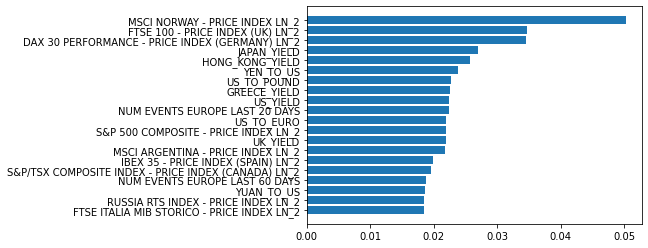

In [542]:
f_i = list(zip(l,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
selected_features = f_i[-20:]
plt.barh([x[0] for x in selected_features],[x[1] for x in selected_features])

plt.show()

In [543]:
s = []
for f in selected_features:
  s.append(f[0])
s


['FTSE ITALIA MIB STORICO - PRICE INDEX LN_2',
 'RUSSIA RTS INDEX - PRICE INDEX LN_2',
 'YUAN_TO_US',
 'NUM EVENTS EUROPE LAST 60 DAYS',
 'S&P/TSX COMPOSITE INDEX - PRICE INDEX (CANADA) LN_2',
 'IBEX 35 - PRICE INDEX (SPAIN) LN_2',
 'MSCI ARGENTINA - PRICE INDEX LN_2',
 'UK_YIELD',
 'S&P 500 COMPOSITE - PRICE INDEX LN_2',
 'US_TO_EURO',
 'NUM EVENTS EUROPE LAST 20 DAYS',
 'US_YIELD',
 'GREECE_YIELD',
 'US_TO_POUND',
 'YEN_TO_US',
 'HONG_KONG_YIELD',
 'JAPAN_YIELD',
 'DAX 30 PERFORMANCE - PRICE INDEX (GERMANY) LN_2',
 'FTSE 100 - PRICE INDEX (UK) LN_2',
 'MSCI NORWAY - PRICE INDEX LN_2']

# Balancing(Oversampling)

In [524]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [547]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE()
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(np.array(X_train[s]), np.array(y_train))

# Predictions

Let's use now XGboot to run the predictions

In [378]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

In [548]:
model = XGBClassifier(n_estimators=1000)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)


In [549]:
from numpy import mean
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.82755


# ROC Analysis

https://towardsdatascience.com/pooled-roc-with-xgboost-and-plotly-553a8169680c

In [574]:
folds = [(train,test) for train, test in cv.split(X, y)]

In [575]:
metrics = ['auc', 'fpr', 'tpr', 'thresholds']
results = {
    'train': {m:[] for m in metrics},
    'val': {m:[] for m in metrics}
}

In [576]:
params = {
    'objective'   : 'binary:logistic',
    'eval_metric' : 'logloss'
}

In [577]:
results

{'train': {'auc': [], 'fpr': [], 'thresholds': [], 'tpr': []},
 'val': {'auc': [], 'fpr': [], 'thresholds': [], 'tpr': []}}

In [578]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve

for train, test in tqdm(folds, total=len(folds)):
    dtrain = xgb.DMatrix(X[train,:], label=y[train])
    dval   = xgb.DMatrix(X[test,:], label=y[test])
    model  = xgb.train(
        dtrain                = dtrain,
        params                = params, 
        evals                 = [(dtrain, 'train'), (dval, 'val')],
        num_boost_round       = 1000,
        verbose_eval          = False,
        early_stopping_rounds = 10,
    )
    sets = [dtrain, dval]
    for i,ds_name in enumerate(results.keys()):
        y_preds              = model.predict(sets[i])
        labels               = sets[i].get_label()
        fpr, tpr, thresholds = roc_curve(labels, y_preds)
        results[ds_name]['fpr'].append(fpr)
        results[ds_name]['tpr'].append(tpr)
        results[ds_name]['thresholds'].append(thresholds)
        results[ds_name]['auc'].append(roc_auc_score(labels, y_preds))

  0%|          | 0/15 [00:00<?, ?it/s]

In [581]:
i

15

In [583]:
import plotly.graph_objects as go

kind = 'val'
c_fill      = 'rgba(52, 152, 219, 0.2)'
c_line      = 'rgba(52, 152, 219, 0.5)'
c_line_main = 'rgba(41, 128, 185, 1.0)'
c_grid      = 'rgba(189, 195, 199, 0.5)'
c_annot     = 'rgba(149, 165, 166, 0.5)'
c_highlight = 'rgba(192, 57, 43, 1.0)'
fpr_mean    = np.linspace(0, 1, 15)

interp_tprs = []
for i in range(15):
    fpr           = results[kind]['fpr'][i]
    tpr           = results[kind]['tpr'][i]
    interp_tpr    = np.interp(fpr_mean, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)
tpr_mean     = np.mean(interp_tprs, axis=0)
tpr_mean[-1] = 1.0
tpr_std      = 2*np.std(interp_tprs, axis=0)
tpr_upper    = np.clip(tpr_mean+tpr_std, 0, 1)
tpr_lower    = tpr_mean-tpr_std
auc          = np.mean(results[kind]['auc'])
fig = go.Figure([
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_upper,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "skip",
        showlegend = False,
        name       = 'upper'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_lower,
        fill       = 'tonexty',
        fillcolor  = c_fill,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "skip",
        showlegend = False,
        name       = 'lower'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_mean,
        line       = dict(color=c_line_main, width=2),
        hoverinfo  = "skip",
        showlegend = True,
        name       = f'AUC: {auc:.3f}')
])
fig.add_shape(
    type ='line', 
    line =dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_layout(
    template    = 'plotly_white', 
    title_x     = 0.5,
    xaxis_title = "1 - Specificity",
    yaxis_title = "Sensitivity",
    width       = 800,
    height      = 800,
    legend      = dict(
        yanchor="bottom", 
        xanchor="right", 
        x=0.95,
        y=0.01,
    )
)
fig.update_yaxes(
    range       = [0, 1],
    gridcolor   = c_grid,
    scaleanchor = "x", 
    scaleratio  = 1,
    linecolor   = 'black')
fig.update_xaxes(
    range       = [0, 1],
    gridcolor   = c_grid,
    constrain   = 'domain',
    linecolor   = 'black')